In [163]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [164]:
df = pd.read_excel("Sourcing case students excel.xlsx", sheet_name=1)
df.drop('LEC ID', axis=1, inplace=True)
df.head()

,Date,Units Sold
0,2013-01-08,40
1,2013-01-09,5
2,2013-01-10,14
3,2013-01-11,8
4,2013-01-12,4


In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        418 non-null    datetime64[ns]
 1   Units Sold  418 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.7 KB


In [166]:
#drop the rows with missing values
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Units Sold
Date,
2013-01-08,40
2013-01-09,5
2013-01-10,14
2013-01-11,8
2013-01-12,4


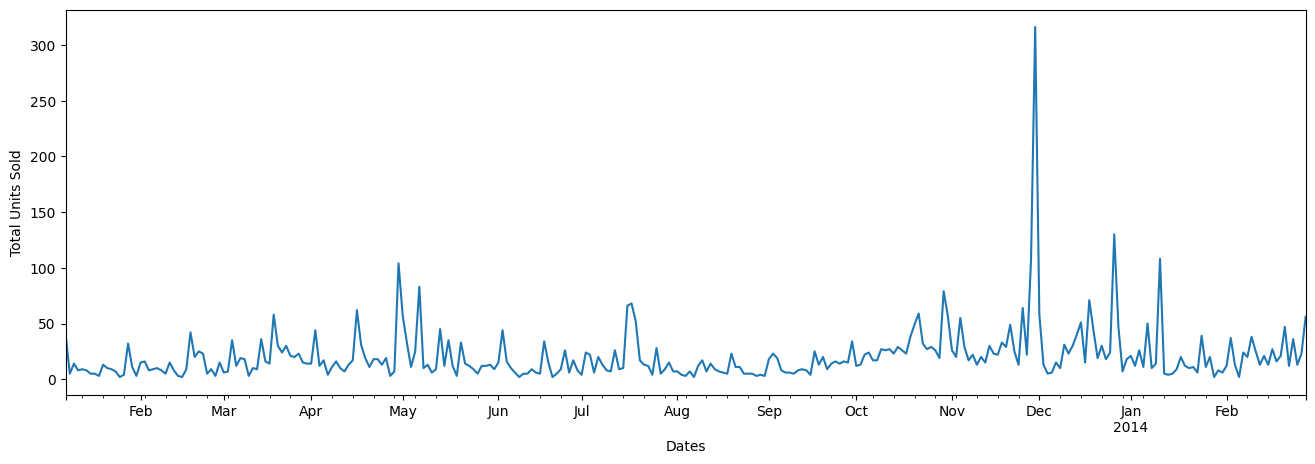

In [167]:
#Basic Data Plot
df = df.asfreq('B')
ax = df['Units Sold'].plot(figsize = (16,5))
ax.set(xlabel='Dates', ylabel='Total Units Sold');

In [168]:
print(df.index.duplicated().sum())  # This will print the count of duplicate dates


0


In [169]:
#Seasonal Decompose Plots
if isinstance(df.index, pd.PeriodIndex):
    df.index = df.index.to_timestamp()
if df.index.inferred_freq is None:
    df = df.asfreq('D')



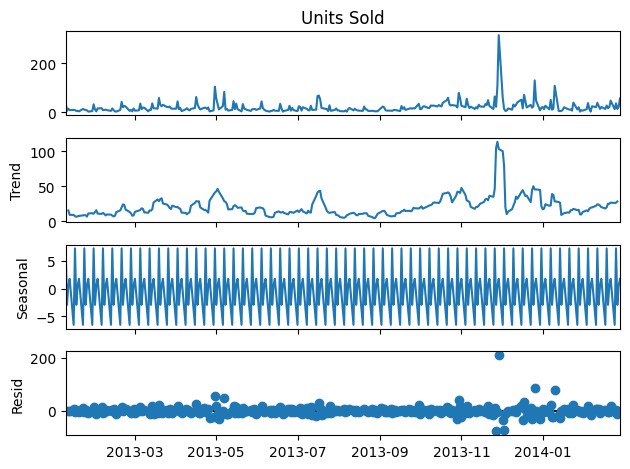

In [170]:
decomposition = seasonal_decompose(df['Units Sold'], model='additive')
decomposition.plot();

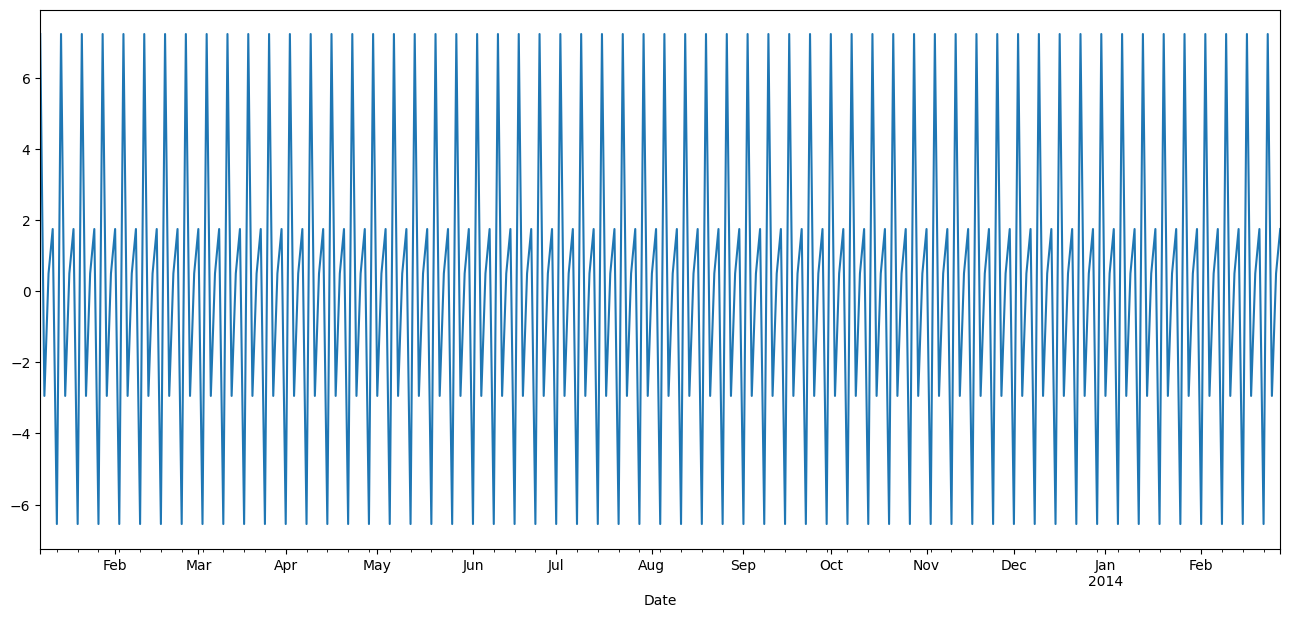

In [171]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,7))
decomposition.seasonal.plot();

Trend Component:

This shows the underlying trend in your data. From the plot, we observe spikes which suggest that there are times when sales peak significantly. The trend component is relatively stable except for these peaks.

Seasonal Component:

This pattern repeats regularly over the dataset, suggesting strong seasonal trends. The consistent peaks and troughs indicate a predictable pattern of sales that could be linked to specific times of the year or month.
Key Insight: This seasonality must be accounted for in any forecasting models, as it strongly influences sales.

Residual Component:

Residuals represent the error of the model or the information not captured by the trend and seasonal components. Ideally, residuals should be randomly scattered around zero, showing no pattern.
Key Insight: Some significant outliers are visible, suggesting occasional deviations from the predicted values based on trend and seasonality alone. These could be due to unexpected events or anomalies in sales data.

## Augmented Dickey-Fuller Test

In [172]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(df['Units Sold'], autolag='AIC')  

# Create a pandas series with the results:
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value

# Print the results
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -3.535208
p-value                          0.007128
# Lags Used                      9.000000
Number of Observations Used    289.000000
Critical Value (1%)             -3.453182
Critical Value (5%)             -2.871593
Critical Value (10%)            -2.572127
dtype: float64


The result of the Dickey-Fuller test provides strong evidence that the time series is stationary. This is crucial because many time series forecasting models, such as ARIMA, require the data to be stationary to provide reliable and meaningful predictions. Stationarity implies that the statistical properties of the series such as mean, variance, and autocorrelation are constant over time, which simplifies the modeling process.

SARIMA Parameters:
p, d, q: Non-Seasonal Parameters

p (AR - Autoregressive): The number of lag observations included in the model. It represents the dependency between an observation and a number of lagged observations.
d (I - Integrated): The number of times that the raw observations are differenced. This is the parameter for making the time series stationary.
q (MA - Moving Average): The size of the moving average window. It represents the dependency between an observation and a residual error from a moving average model applied to lagged observations.

P, D, Q, s: Seasonal Parameters

P (Seasonal AR): Seasonal autoregressive order.
D (Seasonal I): Seasonal differencing order.
Q (Seasonal MA): Seasonal moving average order.
s (Seasonal Periodicity): The length of the seasonal cycle. 


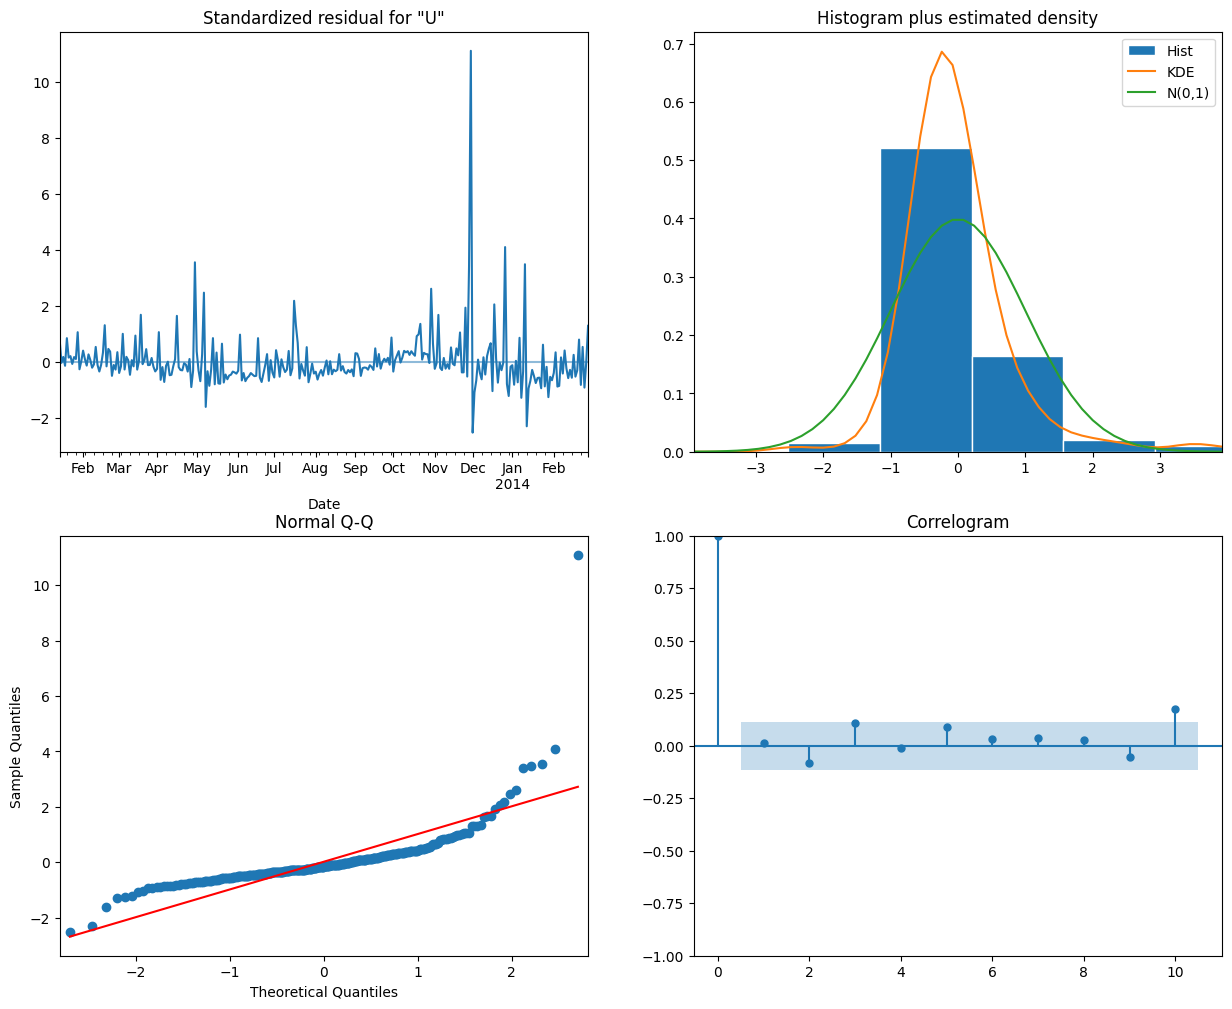

In [173]:
# Define the model parameters

p, d, q = 1, 1, 1  # These are ARIMA parameters
P, D, Q, s = 1, 1, 1, 4  # Seasonal parameters 

# Fit a SARIMA model
model = SARIMAX(df['Units Sold'], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

# Plot the diagnostics to check for any unusual behavior
results.plot_diagnostics(figsize=(15, 12))
plt.show()

1. Standardized Residuals Plot
The standardized residuals plot shows the residuals from the model over time, ideally scattered randomly around the zero line without displaying any clear patterns or systematic structures. From the plot I received, while residuals mostly hover around zero, there are noticeable spikes. These spikes suggest occasional large errors, indicating that the model might not capture some specific data points well or that there are outliers affecting the model’s predictions.

2. Histogram Plus Estimated Density Plot
This plot provides a histogram of the residuals, overlaid with a kernel density estimate (KDE) and a theoretical normal distribution (N(0,1)). The goal here is to check if the residuals are normally distributed—a critical assumption for many statistical tests that may follow model fitting. The KDE suggests that the distribution of residuals has a slight deviation from the normal curve, particularly showing a slight skewness. This observation suggests that the model might benefit from transformations to achieve normality or that certain nonlinear aspects of the data are not captured by the model.

3. Normal Q-Q Plot
The Q-Q (Quantile-Quantile) plot is used to directly compare the quantiles of the residuals against the expected quantiles of a standard normal distribution. Ideally, the points should fall approximately along the red line if the residuals were normally distributed. In the provided plot, most points lie along the line except for the tails, which deviate significantly, especially in the upper tail. This indicates that the residuals have heavier tails than the normal distribution, suggesting the presence of outliers or extreme values the model is not accounting for.

4. Correlogram
The correlogram, or autocorrelation plot, shows the autocorrelation of the residuals up to 10 lags. It's used to determine if there is any leftover pattern in the residuals that should have been captured by the model. In an ideal scenario, all autocorrelations should fall within the blue shaded area, indicating they are not significantly different from zero. The plot I analyzed shows that all autocorrelations are within the confidence interval, suggesting that the model residuals do not exhibit significant autocorrelation, thus confirming that the model has captured the temporal dependencies effectively

In [174]:
split_point = int(len(df) * 0.93)
train, test = df.iloc[:split_point+1], df.iloc[split_point+1:]

# Display the last few entries of the training set and the first few of the test set to verify the split
print("Training set:\n", train.tail())
print("Test set:\n", test.head())
print(test.tail())

Training set:
             Units Sold
Date                  
2014-01-27          11
2014-01-28          20
2014-01-29           2
2014-01-30           8
2014-01-31           6
Test set:
             Units Sold
Date                  
2014-02-03          12
2014-02-04          37
2014-02-05          13
2014-02-06           2
2014-02-07          24
            Units Sold
Date                  
2014-02-24          12
2014-02-25          36
2014-02-26          13
2014-02-27          23
2014-02-28          56


In [175]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a SARIMA model to the training data
model = SARIMAX(train['Units Sold'], 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 4))
results = model.fit(disp=False) 

C:\Users\tashf\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [176]:
forecast = results.get_forecast(steps=len(test))
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

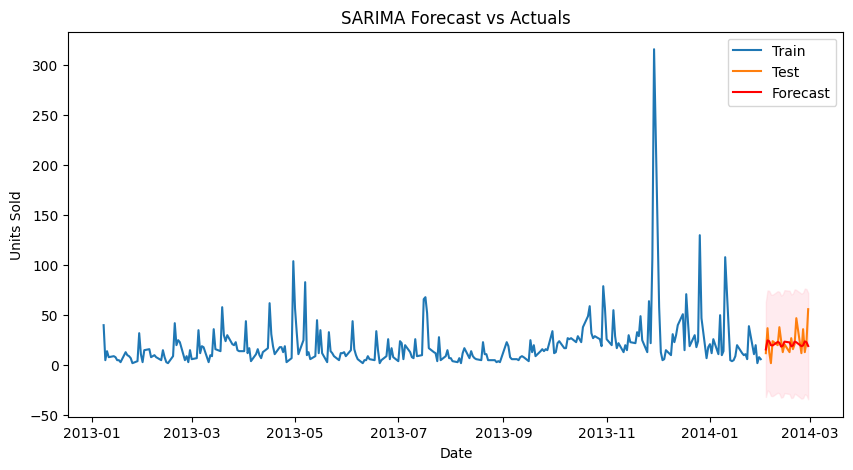

In [177]:
import matplotlib.pyplot as plt

# Plot the forecast alongside the actual values
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['Units Sold'], label='Train')
plt.plot(test.index, test['Units Sold'], label='Test')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='Forecast')
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.show()


In [178]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae = mean_absolute_error(test['Units Sold'], mean_forecast)
rmse = np.sqrt(mean_squared_error(test['Units Sold'], mean_forecast))
mse = mean_squared_error(test['Units Sold'], mean_forecast)
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')


Mean Absolute Error (MAE): 10.12
Root Mean Squared Error (RMSE): 13.26
Mean Squared Error (MSE): 175.78


In [179]:
df_prophet = df.copy()
df_prophet.head()

,Units Sold
Date,
2013-01-08,40
2013-01-09,5
2013-01-10,14
2013-01-11,8
2013-01-14,9


In [180]:
df_prophet.reset_index(inplace=True)
df_prophet.columns = ['ds', 'y']

# Split the data into training and testing sets
split_point = int(len(df) * 0.93)
train, test = df_prophet.iloc[:split_point+1], df_prophet.iloc[split_point+1:]

In [181]:
# Initialize the Prophet model
from prophet import Prophet
model = Prophet(daily_seasonality=True)  
model.fit(train)


18:23:21 - cmdstanpy - INFO - Chain [1] start processing
18:23:21 - cmdstanpy - INFO - Chain [1] done processing


In [182]:
# Create a future DataFrame including dates from the test set
future = model.make_future_dataframe(periods=len(test), freq='B')
forecast = model.predict(future)


In [183]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Extract the predicted values for the test dates
y_pred = forecast[-len(test):]['yhat']

# Calculate MAE and RMSE
mae = mean_absolute_error(test['y'], y_pred)
rmse = np.sqrt(mean_squared_error(test['y'], y_pred))
mse = mean_squared_error(test['y'], y_pred)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Squared Error (MSE): {mse}')

Mean Absolute Error (MAE): 12.411238722371072
Root Mean Squared Error (RMSE): 14.205558638713669
Mean Squared Error (MSE): 201.79789623793255


Arima performs better with lower MSE

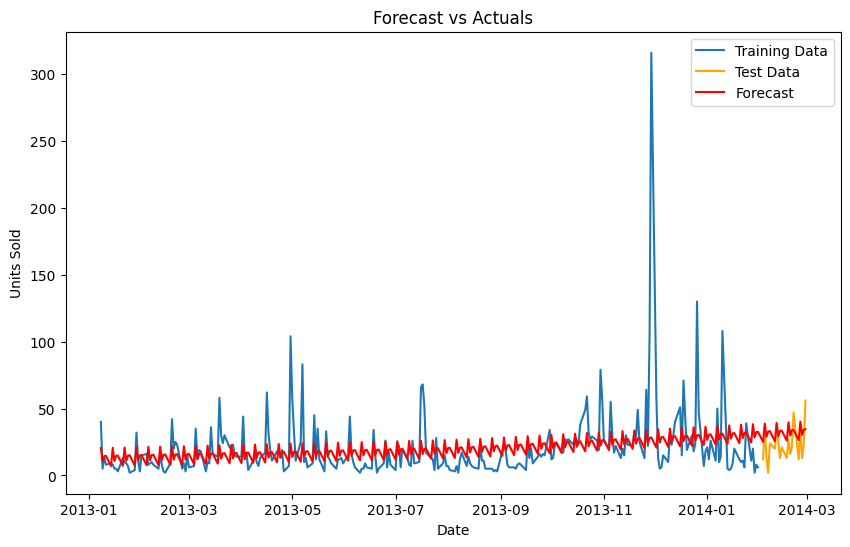

In [184]:
import matplotlib.pyplot as plt

# Plot the observed values
plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Training Data')
plt.plot(test['ds'], test['y'], label='Test Data', color='orange')

# Plot the forecast
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')
#plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.3)

plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.show()


# Shirts to order



In [185]:
# 2014-03-02 max date in data predict until 2014-03-31 for whole month using arima
future_dates = pd.date_range(start='2014-03-03', end='2014-03-31', freq='D')
future_dates

DatetimeIndex(['2014-03-03', '2014-03-04', '2014-03-05', '2014-03-06',
               '2014-03-07', '2014-03-08', '2014-03-09', '2014-03-10',
               '2014-03-11', '2014-03-12', '2014-03-13', '2014-03-14',
               '2014-03-15', '2014-03-16', '2014-03-17', '2014-03-18',
               '2014-03-19', '2014-03-20', '2014-03-21', '2014-03-22',
               '2014-03-23', '2014-03-24', '2014-03-25', '2014-03-26',
               '2014-03-27', '2014-03-28', '2014-03-29', '2014-03-30',
               '2014-03-31'],
              dtype='datetime64[ns]', freq='D')

In [186]:
forecast = results.predict(start='2014-03-03', end='2014-03-23',freq='D')
forecast_df = pd.DataFrame({'Shirts ordered Units': forecast})
forecast_df.head(30)

C:\Users\tashf\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['freq']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


,Shirts ordered Units
2014-03-03,19.854738
2014-03-04,23.895351
2014-03-05,23.147073
2014-03-06,19.257460
2014-03-07,19.983639
2014-03-10,24.024350
2014-03-11,23.276069
2014-03-12,19.386454
2014-03-13,20.112614
2014-03-14,24.153314


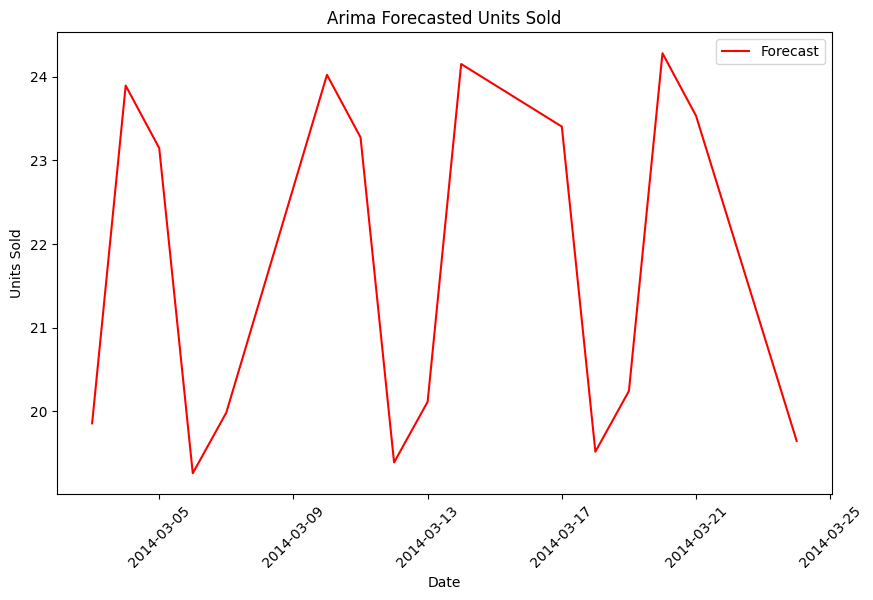

In [187]:
# plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['Shirts ordered Units'], label='Forecast', color='red')
plt.title('Arima Forecasted Units Sold')
plt.xlabel('Date')
plt.ylabel('Units Sold')
# rotate the x-axis labels for better readability
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [188]:
# sum
print("Orders",forecast_df['Shirts ordered Units'].sum())

Orders 347.7137632455809
